<a href="https://colab.research.google.com/github/gabrielvinicios02/ExperimentsMultivariate/blob/f-TEP2-Base/ClassificadorXGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Séries Temporais


<center>
<table><tr><td> <a href="http://www.minds.eng.ufmg.br/"><img src="https://github.com/petroniocandido/pyFTS/raw/master/img/minds_logo_medium.jpeg" alt="MINDS - Machine Intelligence and Data Science Lab" width="100"/></a></td> 
  <td>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</td>
<td><a href="https://pyfts.github.io/pyFTS/"><img src="https://github.com/petroniocandido/pyFTS/raw/master/img/logo_medium.png" alt="pyFTS - Fuzzy Time Series for Python" width="100"/></a></td>
</tr>
</table>
</center>

In [1]:
!pip3 install -U git+https://github.com/PYFTS/pyFTS
#!pip3 install -U pyFTS
!pip3 install SimpSOM
!pip install dispy
#!pip install matplotlib==3.1.3
!pip install matplotlib==3.1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/PYFTS/pyFTS to /tmp/pip-req-build-opo_nxpl
  Running command git clone -q https://github.com/PYFTS/pyFTS /tmp/pip-req-build-opo_nxpl
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.5.2-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.1
    Uninstalling matplotlib-3.1.1:
      Successfully uninstalled matplotlib-3.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.1.1-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.2
    Uninstalling matplotlib-3.5.2:
      Successfully uninstalled matplotlib-3.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
simpsom 2.0.1 requires matplotlib>=3.3.3, but you have matplotlib 3.1.1 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#importing all the necessary libraries 
!pip install pyreadr
import pandas as pd
import seaborn as sns
import numpy as np
import pyreadr as py # library to read .Rdata files in python
import sqlite3
import os
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix,confusion_matrix,classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer,one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, BatchNormalization,concatenate,Flatten,Embedding,Dense,Dropout,MaxPooling2D,Reshape,BatchNormalization
from keras.models import Sequential
from keras import Model,Input
from keras.layers.convolutional import Conv2D,Conv1D
import keras.backend as k
from sklearn.metrics import roc_auc_score,f1_score
import tensorflow as tf
from keras.callbacks import Callback, EarlyStopping
from time import time
from scipy.sparse import hstack
from tensorflow.python.keras.callbacks import TensorBoard
import pickle
import datetime
from tensorflow.keras.utils import to_categorical
import missingno as msno
import warnings
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#reading train data in .R format
a1 = py.read_r("../content/drive/MyDrive/DadosPWFTS/TEP_FaultFree_Training.RData")
a2 = py.read_r("../content/drive/MyDrive/DadosPWFTS/TEP_Faulty_Training.RData")

#reading test data in .R format

#a3 = py.read_r("../content/drive/MyDrive/DadosPWFTS/TEP_FaultFree_Testing.RData")
#a4 = py.read_r("../content/drive/MyDrive/DadosPWFTS/TEP_Faulty_Testing (1).RData")

print("Objects that are present in a1 :",a1.keys())
print("Objects that are present in a2 :",a2.keys())
#print("Objects that are present in a3 :",a3.keys())
#print("Objects that are present in a4 :",a4.keys())

Objects that are present in a1 : odict_keys(['fault_free_training'])
Objects that are present in a2 : odict_keys(['faulty_training'])


In [5]:
#REading the .Rdata files in pandas dataframe and saving it in .csv file
#reading train data
b1 = a1['fault_free_training']
b2 = a2['faulty_training']
#reading test data
#b3 = a3['fault_free_testing']
#b4 = a4['faulty_testing']

# concatinating the train and the test dataset
frames_tr = [b1]
train_ts = pd.concat(frames_tr)
frames_ts = [b2]
test = pd.concat(frames_ts)
#all_data_TEP = [train_ts,test]
#all_TEP = pd.concat(all_data_TEP)

In [6]:
print('Shape of the Train dataset:', train_ts.shape)
print("Shape of the Test dataset:", test.shape)

print("Distrubution of faults in train dataset:")
print(train_ts['faultNumber'].value_counts())

print("Distrubution of faults in test dataset:")
print(test['faultNumber'].value_counts())

Shape of the Train dataset: (250000, 55)
Shape of the Test dataset: (5000000, 55)
Distrubution of faults in train dataset:
0.0    250000
Name: faultNumber, dtype: int64
Distrubution of faults in test dataset:
1     250000
2     250000
19    250000
18    250000
17    250000
16    250000
15    250000
14    250000
13    250000
12    250000
11    250000
10    250000
9     250000
8     250000
7     250000
6     250000
5     250000
4     250000
3     250000
20    250000
Name: faultNumber, dtype: int64


In [7]:
train_ts_2 = train_ts[0:50000]
test_2 = test.loc[test['faultNumber']==4] #funciona filtro dados
test_2 = test_2[0:50000]

In [8]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
from pyFTS.models import hofts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

In [9]:
from pyFTS.data import TAIEX, Malaysia, sunspots, artificial
from statsmodels.tsa.stattools import acf, pacf

datasets = {}

dff = pd.read_excel('../content/drive/MyDrive/DadosPWFTS/DadosFalha.xlsx')
dfn = pd.read_excel('../content/drive/MyDrive/DadosPWFTS/DadosNormais.xlsx')

dados_treino_Falha = dff[0:2300] 
dados_teste_Falha = dff[1800:2300]

dados_treino_Normal = dfn[0:1800] 
dados_teste_Normal = dfn[1500:1800]

## Analisando as Séries Temporais

In [10]:
#Dados sem Falhas

from pyFTS.data import TAIEX, Malaysia, sunspots, artificial
from statsmodels.tsa.stattools import acf, pacf

datasets1 = {}

#datasets1['LIT'] = dados_treino_Falha.get('LIT_2012KS_0251_FilteredSignal')
datasets1['LIT'] = train_ts_2.get('xmeas_6')
#datasets1['SpeedActual'] = dados_treino_Falha.get('_AL_2012KS_06M1_SpeedActual')
datasets1['SpeedActual'] = train_ts_2.get('xmeas_7')
#datasets1['BeltLoad'] = dados_treino_Falha.get('WIT_1085KS_2300_BeltLoad')
datasets1['BeltLoad'] = train_ts_2.get('xmeas_8')
#datasets1['Rate'] = dados_treino_Falha.get('WIT_1085KS_2300_Rate')
datasets1['Rate'] = train_ts_2.get('xmeas_9')

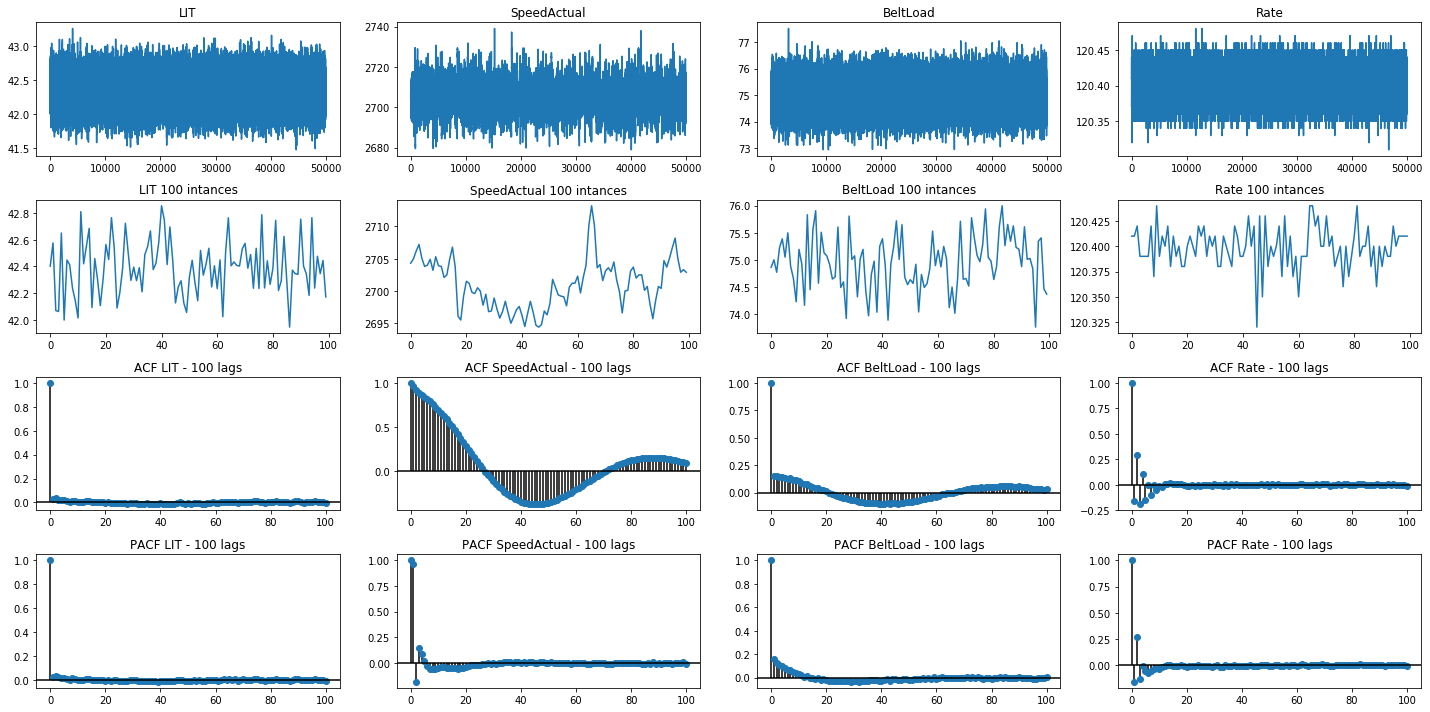

In [11]:
#Dados sem Falhas

fig1, ax = plt.subplots(nrows=4, ncols=4, figsize=[20,10])

for ct, (key, data) in enumerate(datasets1.items()): 
  _lags = np.arange(0,101)
  _acf = acf(data,nlags=100)
  _pacf = pacf(data,nlags=100)
  
  ax[0][ct].set_title("{}".format(key))
  ax[0][ct].plot(data)
  
  ax[1][ct].set_title("{} 100 intances".format(key))
  ax[1][ct].plot(data[:100])
  
  ax[2][ct].set_title("ACF {} - 100 lags".format(key))
  ax[2][ct].plot(_lags, _acf, "o")
  ax[2][ct].vlines(_lags,[0],_acf)
  ax[2][ct].axhline(y=0, color='black')
  
  ax[3][ct].set_title("PACF {} - 100 lags".format(key))
  ax[3][ct].plot(_lags, _pacf, "o")
  ax[3][ct].vlines(_lags,[0],_pacf)
  ax[3][ct].axhline(y=0, color='black')

plt.tight_layout()

In [12]:
#Dados normais - com falhas
from pyFTS.data import TAIEX, Malaysia, sunspots, artificial
from statsmodels.tsa.stattools import acf, pacf

datasets2 = {}

#datasets2['LIT'] = dados_treino_Normal.get('LIT_2012KS_0251_FilteredSignal')
datasets2['LIT'] = test_2.get('xmeas_6')
#datasets2['SpeedActual'] = dados_treino_Normal.get('_AL_2012KS_06M1_SpeedActual')
datasets2['SpeedActual'] = test_2.get('xmeas_7')
#datasets2['BeltLoad'] = dados_treino_Normal.get('WIT_1085KS_2300_BeltLoad')
datasets2['BeltLoad'] = test_2.get('xmeas_8')
#datasets2['Rate'] = dados_treino_Normal.get('WIT_1085KS_2300_Rate')
datasets2['Rate'] = test_2.get('xmeas_9')

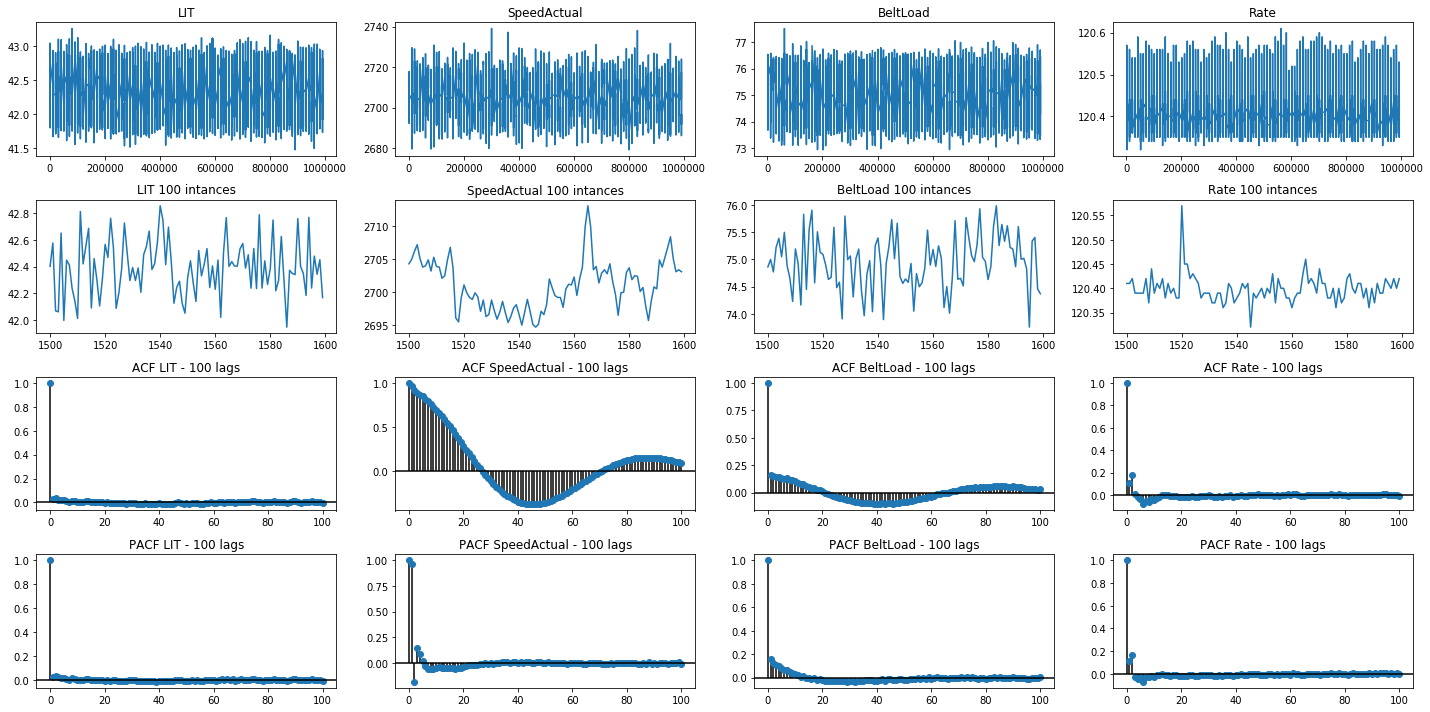

In [13]:
#Dados normais - com falhas

fig2, ax = plt.subplots(nrows=4, ncols=4, figsize=[20,10])

for ct, (key, data) in enumerate(datasets2.items()): 
  _lags = np.arange(0,101)
  _acf = acf(data,nlags=100)
  _pacf = pacf(data,nlags=100)
  
  ax[0][ct].set_title("{}".format(key))
  ax[0][ct].plot(data)
  
  ax[1][ct].set_title("{} 100 intances".format(key))
  ax[1][ct].plot(data[:100])
  
  ax[2][ct].set_title("ACF {} - 100 lags".format(key))
  ax[2][ct].plot(_lags, _acf, "o")
  ax[2][ct].vlines(_lags,[0],_acf)
  ax[2][ct].axhline(y=0, color='black')
  
  ax[3][ct].set_title("PACF {} - 100 lags".format(key))
  ax[3][ct].plot(_lags, _pacf, "o")
  ax[3][ct].vlines(_lags,[0],_pacf)
  ax[3][ct].axhline(y=0, color='black')

plt.tight_layout()

,Partitions,RMSE,MAPE,U
0,Grid,10.37,0.32,5.32


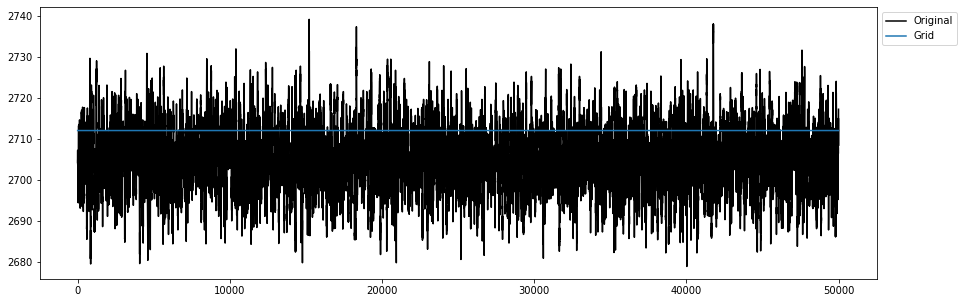

In [14]:
from pyFTS.models import hofts
from pyFTS.partitioners import Grid, FCM, CMeans, Entropy
from pyFTS.benchmarks import Measures

#metodos = [Grid.GridPartitioner, Entropy.EntropyPartitioner, CMeans.CMeansPartitioner ]
metodos = [Grid.GridPartitioner]

k = 4

rows = []

y1=np.asarray(datasets1['SpeedActual'])

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])

ax.plot(y1, label='Original',color='black')

for contador, metodo in enumerate(metodos):
  part = metodo(data=y1, npart=k)
  model = hofts.HighOrderFTS(order=2, partitioner=part)
  model.fit(y1)
  forecasts = model.predict(y1)
  for o in range(model.order):
    forecasts.insert(0,None)
    
  ax.plot(forecasts[:-1], label=part.name)
  
  rmse, mape, u = Measures.get_point_statistics(y1, model)
  
  rows.append([part.name, rmse, mape, u])
  

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

pd.DataFrame(rows, columns=['Partitions','RMSE','MAPE','U'])

In [15]:
#Dados Sem Falhas
from numpy.core.multiarray import concatenate
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures
from pyFTS.common import Util

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y1 = datasets2['LIT']
tam_grupo = 5000
i=0
VT1=[]

for i in range(0,y1.size,tam_grupo):
  grpan = y1[i:i+tam_grupo]
  part = Grid.GridPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model1 = metodo(partitioner=part, progress=False, type='distribution')
    if model1.is_high_order:
      model1 = metodo(partitioner=part, order=1)
    model1.fit(np.asarray(y1))  
  #print(model1)
  _, _, lhs1, rhs1 = pwfts.highorder_fuzzy_markov_chain(model1)
  lhs1t = np.transpose(lhs1)
  V1 = np.c_[rhs1,lhs1t]
  if i == 0 :
    VT1 = V1
  else:
    VT1 = np.c_[VT1,V1]

  print(i)

VT1 = np.transpose(VT1)
print(VT1)

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.18416098 0.17969206 0.17117749]
 [0.78578712 0.7886017  0.79439166]
 [0.03005189 0.03170625 0.03443085]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.18022722 0.78827888 0.0314939 ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.14333126 0.13917649 0.13268806]
 [0.80838725 0.81016677 0.81291567]
 [0.04828149 0.05065674 0.05439627]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.13942587 0.81005965 0.05051447]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.11687

In [16]:
#Dados Sem Falhas
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y2 = datasets2['SpeedActual']
tam_grupo = 5000
i=0
VT2=[]
V2=[]

for i in range(0,y2.size,tam_grupo):
  grpan = y2[i:i+tam_grupo]
  part = Grid.GridPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model2 = metodo(partitioner=part, progress=False, type='distribution')
    if model2.is_high_order:
      model2 = metodo(partitioner=part, order=1)
    model2.fit(np.asarray(y2))  
  #print(model1)
  _, _, lhs2, rhs2 = pwfts.highorder_fuzzy_markov_chain(model2)
  lhs2t = np.transpose(lhs2)
  V2 = np.c_[rhs2,lhs2t]
  if i == 0 :
    VT2 = V2
  else:
    VT2 = np.c_[VT2,V2]

  print(i)

VT2 = np.transpose(VT2)
print(VT2)



0
5000
10000
15000
20000
25000
30000
35000
40000
45000
[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.77881516e-01 7.17594817e-02 5.03912218e-04]
 [8.21937987e-01 8.97358837e-01 8.55153462e-01]
 [1.80497564e-04 3.08816809e-02 1.44342626e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [7.77181839e-02 8.90142840e-01 3.21389758e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.92550030e-01 8.71902496e-02 6.44455597e-04]
 [8.07318934e-01 8.88747371e-01 8.61770453e-01]
 [1.31036087e-04 2.40623796e-02 1.37585091e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0

In [17]:
#Dados Sem Falhas
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y3 = datasets2['BeltLoad']
tam_grupo = 5000
i=0
VT3=[]
V3=[]

for i in range(0,y3.size,tam_grupo):
  grpan = y3[i:i+tam_grupo]
  part = Grid.GridPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model3 = metodo(partitioner=part, progress=False, type='distribution')
    if model3.is_high_order:
      model3 = metodo(partitioner=part, order=1)
    model3.fit(np.asarray(y3))  
  #print(model1)
  _, _, lhs3, rhs3 = pwfts.highorder_fuzzy_markov_chain(model3)
  lhs3t = np.transpose(lhs3)
  V3 = np.c_[rhs3,lhs3t]
  if i == 0 :
    VT3 = V3
  else:
    VT3 = np.c_[VT3,V3]

  print(i)

VT3 = np.transpose(VT3)
print(VT3)

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [5.64326857e-04 5.69106453e-04 2.90970236e-04 7.76143927e-05
  0.00000000e+00]
 [4.26735888e-01 3.23378284e-01 2.85366004e-01 2.25144151e-01
  0.00000000e+00]
 [5.64831053e-01 6.56614873e-01 6.87706010e-01 7.32518035e-01
  7.01173109e-01]
 [7.86873192e-03 1.94377374e-02 2.66367307e-02 4.22541663e-02
  2.98826891e-01]
 [0.00000000e+00 0.00000000e+00 2.84679686e-07 6.03359210e-06
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [3.67849463e-04 2.95143317e-01 6.79594525e-01 2.48939656e-02
  3.43666790e-07]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0

In [18]:
#Dados Sem Falhas
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y4 = datasets2['Rate']
tam_grupo = 5000
i=0
VT4=[]
V4=[]

for i in range(0,y4.size,tam_grupo):
  grpan = y4[i:i+tam_grupo]
  part = Grid.GridPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model4 = metodo(partitioner=part, progress=False, type='distribution')
    if model4.is_high_order:
      model4 = metodo(partitioner=part, order=1)
    model4.fit(np.asarray(y4))  
  #print(model1)
  _, _, lhs4, rhs4 = pwfts.highorder_fuzzy_markov_chain(model4)
  lhs4t = np.transpose(lhs4)
  V4 = np.c_[rhs4,lhs4t]
  if i == 0 :
    VT4 = V4
  else:
    VT4 = np.c_[VT4,V4]

  print(i)

VT4 = np.transpose(VT4)
print(VT4)

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.84249668e-02 2.82059594e-02 1.12500159e-02]
 [9.71495992e-01 9.71715269e-01 9.88562928e-01]
 [7.90412193e-05 7.87711907e-05 1.87055937e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.82108019e-02 9.71710411e-01 7.87873399e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [3.02685847e-02 3.00598753e-02 1.29631669e-02]
 [9.69656264e-01 9.69865579e-01 9.86925205e-01]
 [7.51512467e-05 7.45452237e-05 1.11627836e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0

In [19]:
#Dados Com Falhas
from numpy.core.multiarray import concatenate
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures
from pyFTS.common import Util

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y1 = datasets1['LIT']
tam_grupo = 5000
i=0
VU1=[]

for i in range(0,y1.size,tam_grupo):
  grpan = y1[i:i+tam_grupo]
  part = Grid.GridPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model1 = metodo(partitioner=part, progress=False, type='distribution')
    if model1.is_high_order:
      model1 = metodo(partitioner=part, order=1)
    model1.fit(np.asarray(y1))  
  #print(model1)
  _, _, lhs1, rhs1 = pwfts.highorder_fuzzy_markov_chain(model1)
  lhs1t = np.transpose(lhs1)
  V1 = np.c_[rhs1,lhs1t]
  if i == 0 :
    VU1 = V1
  else:
    VU1 = np.c_[VU1,V1]

  print(i)

VU1 = np.transpose(VU1)
print(VU1)

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.18413397 0.17968983 0.17119747]
 [0.7858119  0.78860166 0.79437079]
 [0.03005414 0.0317085  0.03443174]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.18022122 0.78828265 0.03149612]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.1439146  0.13978303 0.13327759]
 [0.80809313 0.80985686 0.81264563]
 [0.04799227 0.0503601  0.05407678]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.14003282 0.80975202 0.05021516]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.11749

In [20]:
#Dados Com Falhas
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y2 = datasets1['SpeedActual']
tam_grupo = 5000
i=0
VU2=[]
V2=[]

for i in range(0,y2.size,tam_grupo):
  grpan = y2[i:i+tam_grupo]
  part = Grid.GridPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model2 = metodo(partitioner=part, progress=False, type='distribution')
    if model2.is_high_order:
      model2 = metodo(partitioner=part, order=1)
    model2.fit(np.asarray(y2))  
  #print(model1)
  _, _, lhs2, rhs2 = pwfts.highorder_fuzzy_markov_chain(model2)
  lhs2t = np.transpose(lhs2)
  V2 = np.c_[rhs2,lhs2t]
  if i == 0 :
    VU2 = V2
  else:
    VU2 = np.c_[VU2,V2]

  print(i)

VU2 = np.transpose(VU2)
print(VU2)

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.77583150e-01 7.12234062e-02 5.01745526e-04]
 [8.22233818e-01 8.97597544e-01 8.54990518e-01]
 [1.83031557e-04 3.11790501e-02 1.44507737e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [7.71324241e-02 8.90403405e-01 3.24641713e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.92222324e-01 8.66692730e-02 6.43391111e-04]
 [8.07644318e-01 8.89081821e-01 8.61740249e-01]
 [1.33358274e-04 2.42489057e-02 1.37616360e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0

In [21]:
#Dados Com Falhas
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y3 = datasets1['BeltLoad']
tam_grupo = 5000
i=0
VU3=[]
V3=[]

for i in range(0,y3.size,tam_grupo):
  grpan = y3[i:i+tam_grupo]
  part = Grid.GridPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model3 = metodo(partitioner=part, progress=False, type='distribution')
    if model3.is_high_order:
      model3 = metodo(partitioner=part, order=1)
    model3.fit(np.asarray(y3))  
  #print(model1)
  _, _, lhs3, rhs3 = pwfts.highorder_fuzzy_markov_chain(model3)
  lhs3t = np.transpose(lhs3)
  V3 = np.c_[rhs3,lhs3t]
  if i == 0 :
    VU3 = V3
  else:
    VU3 = np.c_[VU3,V3]

  print(i)

VU3 = np.transpose(VU3)
print(VU3)

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [5.90701467e-04 5.69557523e-04 2.91067098e-04 7.87638691e-05
  0.00000000e+00]
 [4.27272188e-01 3.23596696e-01 2.85611431e-01 2.25367228e-01
  0.00000000e+00]
 [5.64315211e-01 6.56461517e-01 6.87546817e-01 7.32442775e-01
  6.99150409e-01]
 [7.82189979e-03 1.93722288e-02 2.65503796e-02 4.21047406e-02
  3.00849591e-01]
 [0.00000000e+00 0.00000000e+00 3.05460165e-07 6.49239903e-06
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [3.68174939e-04 2.95395001e-01 6.79427371e-01 2.48090850e-02
  3.68608476e-07]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0

In [22]:
#Dados Com Falhas
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y4 = datasets1['Rate']
tam_grupo = 5000
i=0
VU4=[]
V4=[]

for i in range(0,y4.size,tam_grupo):
  grpan = y4[i:i+tam_grupo]
  part = Grid.GridPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model4 = metodo(partitioner=part, progress=False, type='distribution')
    if model4.is_high_order:
      model4 = metodo(partitioner=part, order=1)
    model4.fit(np.asarray(y4))  
  #print(model1)
  _, _, lhs4, rhs4 = pwfts.highorder_fuzzy_markov_chain(model4)
  lhs4t = np.transpose(lhs4)
  V4 = np.c_[rhs4,lhs4t]
  if i == 0 :
    VU4 = V4
  else:
    VU4 = np.c_[VU4,V4]

  print(i)

VU4 = np.transpose(VU4)
print(VU4)

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [4.67413329e-03 3.69713543e-03 2.94483717e-03]
 [9.93335935e-01 9.93630455e-01 9.93666048e-01]
 [1.98993211e-03 2.67240926e-03 3.38911495e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.67329627e-03 9.93629841e-01 3.69686291e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [7.63184137e-03 6.05441166e-03 5.22137070e-03]
 [9.91537378e-01 9.92637508e-01 9.93111917e-01]
 [8.30780617e-04 1.30808003e-03 1.66671270e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0

In [33]:
ytst1 = np.ones(110)
ytst2 = np.zeros(110)
ytst = np.concatenate((ytst1,ytst2))

In [34]:
#Unir todas as matrizes geradas
BaseT1 = np.transpose(np.concatenate([np.transpose(VT1),np.transpose(VT2),np.transpose(VT3),np.transpose(VT4)]))
BaseT2 = np.transpose(np.concatenate([np.transpose(VU1),np.transpose(VU2),np.transpose(VU3),np.transpose(VU4)]))
BaseT3 = np.c_[np.transpose(BaseT1), np.transpose(BaseT2)]
BaseT4 = np.c_[np.transpose(BaseT3),ytst]

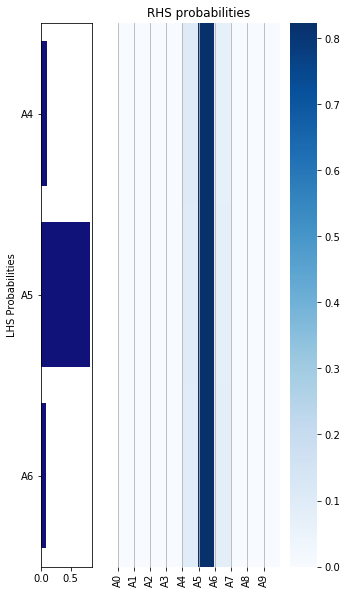

In [35]:
pwfts.visualize_distributions(model1)

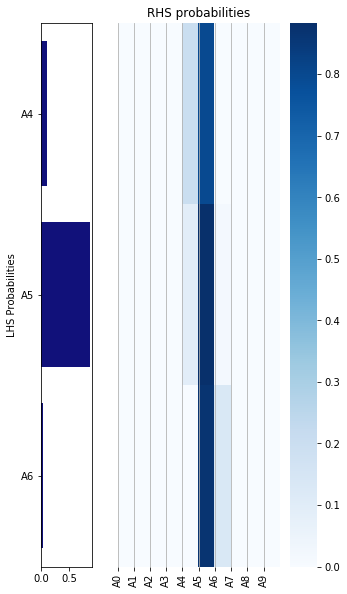

In [36]:
pwfts.visualize_distributions(model2)

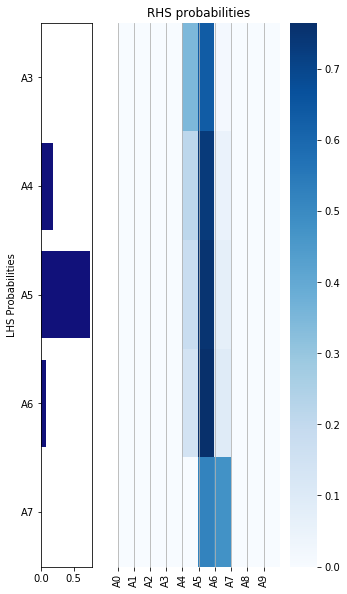

In [37]:
pwfts.visualize_distributions(model3)

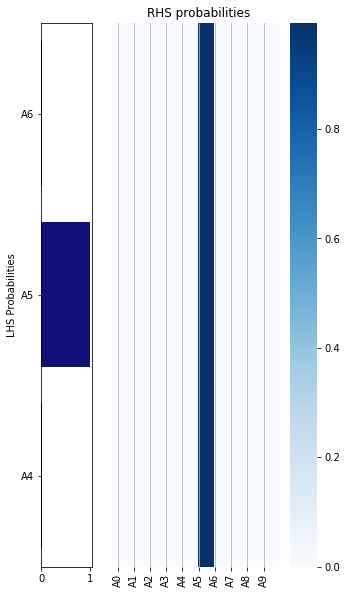

In [38]:
pwfts.visualize_distributions(model4)

In [39]:
#dataset = pd.read_excel('../content/sample_data/Base.xlsx')
#x = dataset.iloc[:,:-1].values
#y = dataset.iloc[:,-1].values
x = BaseT4[:,:-1]
y = BaseT4[:,-1]

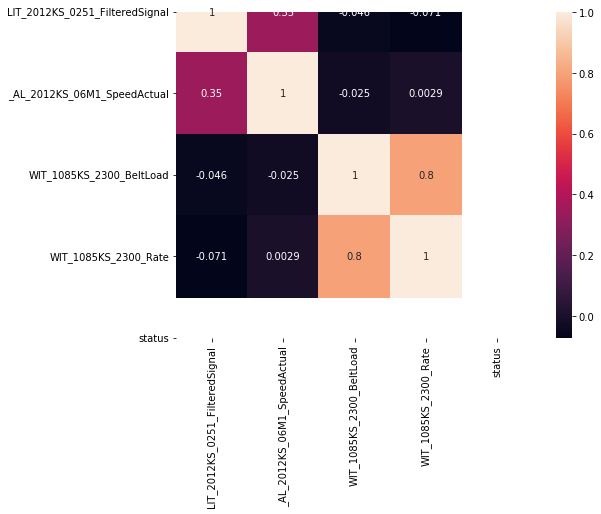

In [40]:
import seaborn as sns
#dataset2 = pd.read_excel('../content/sample_data/Base.xlsx')
corr_df = dff.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()

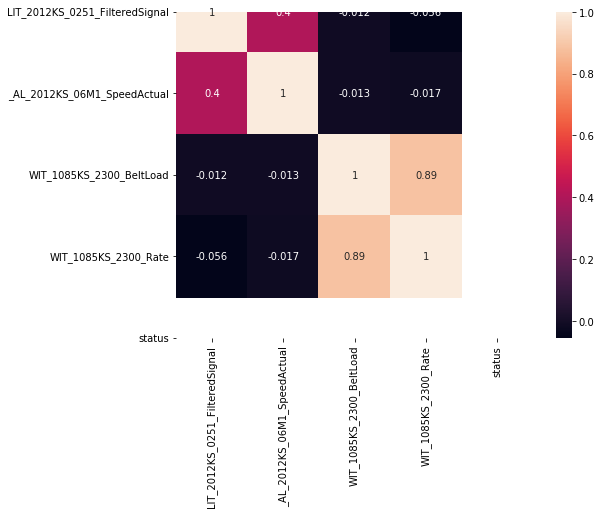

In [41]:
import seaborn as sns
#dataset2 = pd.read_excel('../content/sample_data/Base.xlsx')
corr_df = dfn.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()

In [42]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x , y, test_size = 0.2, random_state = 10)

In [43]:
from xgboost import XGBClassifier
Classifier = XGBClassifier()
Classifier.fit(x_train, y_train)

XGBClassifier()

Matriz de confusão

In [44]:
from sklearn.metrics import confusion_matrix, accuracy_score
ypred = Classifier.predict(x_test)
cm = confusion_matrix(y_test, ypred)
print(cm)

[[ 5 17]
 [ 5 17]]


Precisão

In [45]:
accuracy_score(y_test, ypred)

0.5

In [46]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = Classifier, X = x_train, y = y_train, cv = 2)

print(accuracies.mean()*100)
print(accuracies.std()*100)

63.63636363636363
3.409090909090906
